# Week 12

In [25]:
# renv::activate()
set.seed(380)

#### Packages we will require this week

In [26]:
packages <- c(
    # Old packages
    "ISLR2",
    "dplyr",
    "tidyr",
    "readr",
    "purrr",
    "repr",
    "tidyverse",
    "kableExtra",
    "IRdisplay",
    # NEW
    "torch",
    "torchvision",
    "luz"
)
# renv::install(packages)
sapply(packages, require, character.only=TRUE)

ISLR2       dplyr       tidyr       readr       purrr        repr 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
  tidyverse  kableExtra   IRdisplay       torch torchvision         luz 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE

------------------------------------------------------------------------

### Agenda:

1.  Real-world neural network classification
2.  Dataloaders
3.  Torch for image classification

<br><br><br>

## Titanic

In [27]:
url <- "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"

df <- read_csv(url) %>%
    mutate_if(\(x) is.character(x), as.factor) %>%
    mutate(y = Survived) %>%
    select(-c(Name, Survived)) %>%
    (\(x) {
        names(x) <- tolower(names(x))
        x
    })


Rows: 887 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (2): Name, Sex
dbl (6): Survived, Pclass, Age, Siblings/Spouses Aboard, Parents/Children Ab...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Breast Cancer Prediction

In [4]:
# url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

# col_names <- c("id", "diagnosis", paste0("feat", 1:30))

# df <- read_csv(
#         url, col_names, col_types = cols()
#     ) %>% 
#     select(-id) %>% 
#     mutate(y = ifelse(diagnosis == "M", 1, 0)) %>%
#     select(-diagnosis)


# df %>% head

### Train/Test Split

In [28]:
k <- 5

test_ind <- sample(
    1:nrow(df), 
    floor(nrow(df) / k),
    replace=FALSE
)
test_ind

[1] 852 268 137  70 635 821 533   1 539 748 577 773 103 437 580  42  25 795
 [19] 227  28 120 736 718 650 117 311 750 431 147 128 315 304 744 873 318 683
 [37] 244 276 436 769  24 401 568 631 711 802 165 497 707  44 222 416 509 572
 [55] 586 713 445 199 278 627 337 286  67 258 557 616 811 450 702 525 338  85
 [73] 837 696 386 335 452 219 228 506  37  34  46 218 423 453 139 566 855 458
 [91] 846  39 660 723 432 673 464 576 200 724 722 629 388 485 648 779 608  10
[109] 556 489 363 242 814  36 395  82 618 771 886 302 615  73 349 333 330  83
[127]   3 653 853 134  96 149 776 628 749 204 232 734 867 530 291 865 762 164
[145] 836 610 701  98 755 503 301 198 719 598 688 518 161 465 523 862 659  40
[163] 567 354 371 520 777 858 584 116 314 756 357 841 496 344 486

In [29]:
df_train <- df[-test_ind, ]
df_test  <- df[test_ind, ]
nrow(df_train)
nrow(df_train) + nrow(df_test) == nrow(df)

[1] 710

[1] TRUE

### Benchmark with Logistic Regression

In [30]:
fit_glm <- glm(
    y ~ ., 
    df_train %>% mutate_at("y", factor), 
    family = binomial()
)

glm_test <- predict(
    fit_glm, 
    df_test,
    output = "response"
)

glm_preds <- ifelse(glm_test > 0.5, 1, 0)
table(glm_preds, df_test$y)

         
glm_preds   0   1
        0 105  23
        1   9  40

### Neural Net Model

In [31]:
NNet <- nn_module(
  initialize = function(p, q1, q2, q3) {  
    self$hidden1 <- nn_linear(p, q1)
    self$hidden2 <- nn_linear(q1, q2)
    self$hidden3 <- nn_linear(q2, q3)
    self$output <- nn_linear(q3, 1)
    self$activation <- nn_relu()
    self$sigmoid <- nn_sigmoid()
  },
    
  forward = function(x) {
    x %>% 
      self$hidden1() %>% self$activation() %>% 
      self$hidden2() %>% self$activation() %>% 
      self$hidden3() %>% self$activation() %>% 
      self$output() %>% self$sigmoid()
  }
)

### Fit using Luz

If a model has 0 intercept then when the intercept is 0 then everything
else is also 0. This can be useful at times. For example if modeling
horsepower to car price then it makes sense that if the horsepower is 0
then so should the price

In [32]:
M <- model.matrix(y ~ 0 + ., data = df_train)

In [33]:
fit_nn <- NNet %>% 
    # setup model
    setup(loss = nn_bce_loss(),
        optimizer = optim_adam,
        metrics = list(luz_metric_accuracy())) %>%
    # set the hyperparameters
    set_hparams(p=ncol(M), q1 = 256, q2 = 128, q3 = 64) %>%
    set_opt_hparams(lr = 0.005) %>%
    # fit the model
    fit(data = list(
            model.matrix(y ~ 0 + ., data = df_train),
            df_train %>% select(y) %>% as.matrix
        ), 
        valid_data = list(
            model.matrix(y ~ 0 + ., data = df_test),
            df_test %>% select(y) %>% as.matrix
        ),
        epochs = 50,
        verbose = TRUE)

Epoch 1/50


Train metrics: Loss: 0.6901 - Acc: 12.5
Valid metrics: Loss: 0.6925 - Acc: 10.7966
Epoch 2/50
Train metrics: Loss: 0.6124 - Acc: 12.5909
Valid metrics: Loss: 0.6512 - Acc: 10.7966
Epoch 3/50
Train metrics: Loss: 0.6 - Acc: 12.5909
Valid metrics: Loss: 0.6183 - Acc: 10.7966
Epoch 4/50
Train metrics: Loss: 0.5744 - Acc: 12.6818
Valid metrics: Loss: 0.6428 - Acc: 10.7966
Epoch 5/50
Train metrics: Loss: 0.5693 - Acc: 12.5909
Valid metrics: Loss: 0.5945 - Acc: 10.7966
Epoch 6/50
Train metrics: Loss: 0.5419 - Acc: 12.5909
Valid metrics: Loss: 0.6765 - Acc: 10.7966
Epoch 7/50
Train metrics: Loss: 0.537 - Acc: 12.6364
Valid metrics: Loss: 0.5398 - Acc: 10.7966
Epoch 8/50
Train metrics: Loss: 0.5204 - Acc: 12.5
Valid metrics: Loss: 0.5567 - Acc: 10.7966
Epoch 9/50
Train metrics: Loss: 0.5016 - Acc: 12.5909
Valid metrics: Loss: 0.4832 - Acc: 10.7966
Epoch 10/50
Train metrics: Loss: 0.4776 - Acc: 12.5
Valid metrics: Loss: 0.4836 - Acc: 10.7966
Epoch 11/50
Train metrics: Loss: 0.4697 - Acc: 12.545

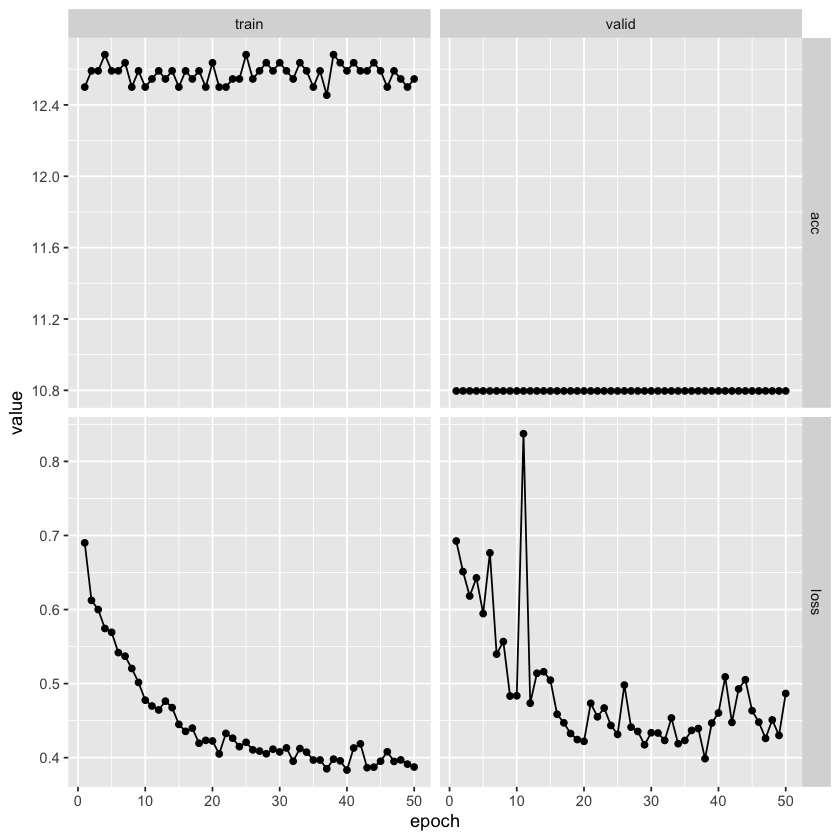

In [34]:
plot(fit_nn)

In [38]:
nn_test <- predict(
    fit_nn, 
    model.matrix(y ~ . - 1, data = df_test)
)

nn_preds <- ifelse(nn_test > 0.5, 1, 0)
table(nn_preds, df_test$y)
table(glm_preds, df_test$y)

        
nn_preds   0   1
       0 108  34
       1   6  29

         
glm_preds   0   1
        0 105  23
        1   9  40

In this case the neural net did worse than logistic regression but the
good part is that we can change some parameters like the learning rate
that will give us better results. Also these were small data sets but if
we were to do this with bigger ones then the neural nets would
outperform the logistic regression models in a more noticable way.

<br><br><br><br>

------------------------------------------------------------------------

### DataLoaders

-   Dataloaders are a key component in the machine learning pipeline.

-   They handle loading and preprocessing data in a way that is
    efficient for training and evaluating models.

-   Dataloaders make it easy to work with large datasets by loading the
    data in smaller chunks (called **batches**) and applying
    transformations *on-the-fly*.

In the context of machine learning, a DataLoader is a utility used for
efficiently loading and processing data during the training or
evaluation of models, particularly in deep learning frameworks like
PyTorch or TensorFlow.

1.  **Batching**: DataLoaders typically load data in batches. Instead of
    loading the entire dataset at once, which may not fit into memory
    for large datasets, DataLoader loads a small subset (batch) of the
    data at a time. Batching is crucial for training deep learning
    models efficiently, as it allows the model to update its parameters
    based on multiple samples at once, which often leads to more stable
    training and faster convergence.

2.  **Shuffling**: When training machine learning models, it’s common
    practice to shuffle the dataset before each epoch (complete pass
    through the dataset). Shuffling ensures that the model doesn’t learn
    from the order of the data and helps prevent any bias that might
    arise from the order of the samples. DataLoader typically provides
    an option to shuffle the data while loading batches.

3.  **Parallelism**: Many modern deep learning frameworks support
    parallel processing, which can significantly speed up data loading.
    DataLoader often leverages this parallelism by loading batches in
    parallel, especially when the data is stored on disk or in remote
    storage systems.

4.  **Data Transformation**: DataLoader often includes functionality for
    applying transformations to the data on-the-fly. These
    transformations can include data augmentation (e.g., random
    rotations, flips, crops for image data), normalization (scaling
    pixel values, z-score normalization), or any other preprocessing
    steps required for the model.

5.  **Integration with Frameworks**: DataLoader is typically integrated
    into deep learning frameworks such as PyTorch or TensorFlow, making
    it easy to use with other components of the framework like models,
    loss functions, and optimizers.

##### Why use Dataloaders?

> -   **Efficient memory management:** loading data in smaller chunks
>     reduces memory usage.
>
> -   **Parallelism:** supports asynchronous data loading for faster
>     processing.
>
> -   **Preprocessing:** apply data transformations on-the-fly during
>     training and evaluation.
>
> -   **Flexibility:** easily switch between different datasets or
>     preprocessing steps.
>
> -   **Standardization:** consistent data format across various machine
>     learning projects.

In [39]:
#?dataloader

dataloader                package:torch                R Documentation

_D_a_t_a _l_o_a_d_e_r. _C_o_m_b_i_n_e_s _a _d_a_t_a_s_e_t _a_n_d _a _s_a_m_p_l_e_r, _a_n_d _p_r_o_v_i_d_e_s _s_i_n_g_l_e- _o_r
_m_u_l_t_i-_p_r_o_c_e_s_s _i_t_e_r_a_t_o_r_s _o_v_e_r _t_h_e _d_a_t_a_s_e_t.

_D_e_s_c_r_i_p_t_i_o_n:

     Data loader. Combines a dataset and a sampler, and provides
     single- or multi-process iterators over the dataset.

_U_s_a_g_e:

     dataloader(
       dataset,
       batch_size = 1,
       shuffle = FALSE,
       sampler = NULL,
       batch_sampler = NULL,
       num_workers = 0,
       collate_fn = NULL,
       pin_memory = FALSE,
       drop_last = FALSE,
       timeout = -1,
       worker_init_fn = NULL,
       worker_globals = NULL,
       worker_packages = NULL
     )
     
_A_r_g_u_m_e_n_t_s:

 dataset: (Dataset): dataset from which to load the data.

batch_

the transform function takes an input, converts it into a PyTorch
tensor, flattens the tensor, and then normalizes its values by dividing
each element by 255. This is often used as a preprocessing step for
image data before feeding it into a neural network

In [ ]:
transform <- function(x) {
    x %>% 
    torch_tensor() %>%
    torch_flatten() %>%
    torch_div(255)
}

In [40]:
dir <- "./mnist"

train_ds <- torchvision::mnist_dataset(
    root = dir,
    train = TRUE,
    download = TRUE,
    transform = transform)

test_ds <- torchvision::mnist_dataset(
    root = dir,
    train = FALSE,
    download = TRUE,
    transform = transform) 


In R, an “environment” is a data structure that stores a collection of
symbol-value pairs, similar to a dictionary or a hash table in other
programming languages. Each symbol (or variable name) in R is associated
with a value, and these associations are stored within an environment.

[1] "environment"

[1] 60000

[1] 60000    28    28

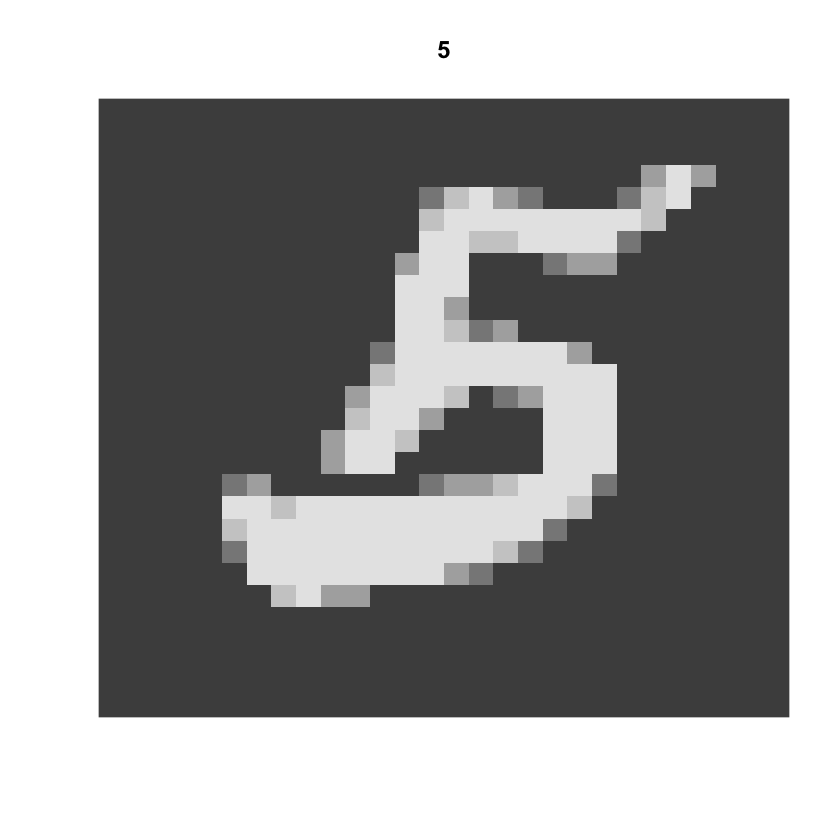

In [50]:
typeof(train_ds)
length(train_ds)
dim(train_ds$data)
x <- train_ds$data[40000, , ] %>% t
image(x[1:28, 28:1], useRaster=TRUE, axes = FALSE, col = gray.colors(1000), main = train_ds$targets[40000]-1)


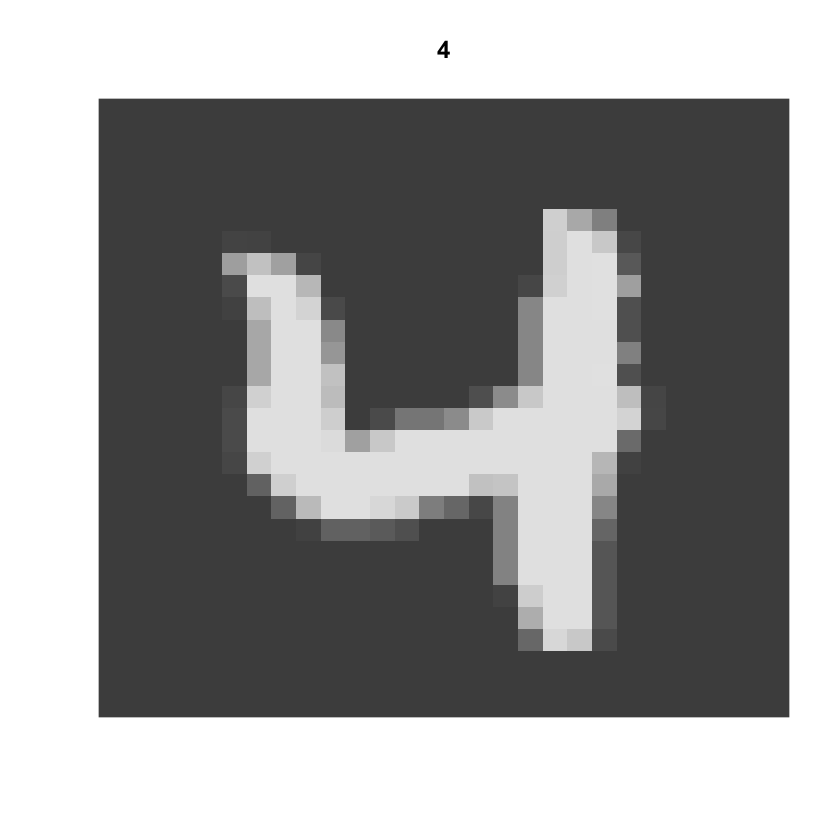

In [57]:
i <- sample(1:length(train_ds), 1)
x <- train_ds$data[i, , ] %>% t
image(x[1:28, 28:1], useRaster=TRUE, axes = FALSE, col = gray.colors(1000), main = train_ds$targets[i]-1)

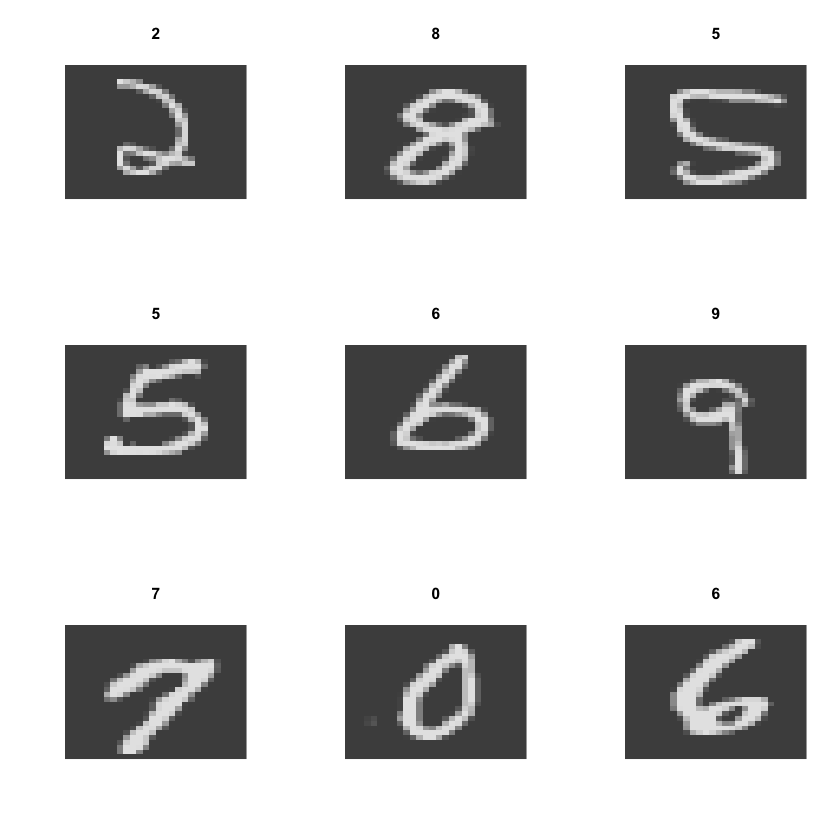

In [58]:

par(mfrow = c(3,3))
for (iter in 1:9){
    i <- sample(1:length(train_ds), 1)
    x <- train_ds$data[i, , ] %>% t
    image(x[1:28, 28:1], useRaster=TRUE, axes = FALSE, col = gray.colors(1000), main = train_ds$targets[i]-1)   
}

<br><br><br><br> <br><br><br><br>

------------------------------------------------------------------------

# Image Classification

In [60]:
train_dl <- dataloader(train_ds, batch_size = 1024, shuffle = TRUE)
test_df <- dataloader(test_ds, batch_size = 1024)
typeof(train_dl)

[1] "environment"

<dataloader>
  Public:
    .auto_collation: active binding
    .dataset_kind: map
    .has_getbatch: FALSE
    .index_sampler: active binding
    .iter: function () 
    .length: function () 
    batch_sampler: utils_sampler_batch, utils_sampler, R6
    batch_size: 1024
    clone: function (deep = FALSE) 
    collate_fn: function (batch) 
    dataset: mnist, dataset, R6
    drop_last: FALSE
    generator: NULL
    initialize: function (dataset, batch_size = 1, shuffle = FALSE, sampler = NULL, 
    multiprocessing_context: NULL
    num_workers: 0
    pin_memory: FALSE
    sampler: utils_sampler_random, utils_sampler, R6
    timeout: -1
    worker_globals: NULL
    worker_init_fn: NULL
    worker_packages: NULL

In [62]:
NNet_10 <- nn_module(
    initialize = function(p, q1, q2, q3, o){
        self$hidden1 <- nn_linear(p, q1) 
        self$hidden2 <- nn_linear(q1, q2)
        self$hidden3 <- nn_linear(q2, q3)
        self$output <- nn_linear(q3, o)
        self$activation <- nn_relu()
    },
    forward = function(x){
        x %>% 
        self$hidden1() %>% self$activation() %>%
        self$hidden2() %>% self$activation() %>%
        self$hidden3() %>% self$activation() %>%
        self$output()
    }
)

In [63]:
fit_nn <- NNet_10 %>% 
    # setup model
    setup(loss = nn_cross_entropy_loss(),
        optimizer = optim_adam,
        metrics = list(luz_metric_accuracy())) %>%
    # set the hyperparameters
    set_hparams(p=28*28, q1 = 256, q2 = 128, q3 = 64, o = 10) %>%
    set_opt_hparams(lr = 0.05) %>%
    # fit the model
    fit(data = train_dl,
        # valid_data = test_dl
        epochs = 5,
        verbose = TRUE)

Epoch 1/5


ERROR: Error in create_fn_name(fun_name, fun_type, nd_args, args, expected_types): Can't convert argument:input
